In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.special import logsumexp

# Set some defaults
plt.rc("axes.spines", top=False, right=False)

sns.set_theme(context="paper", font_scale=1.2)
sns.set_style("ticks")

# Import python library/function for function optimization
import scipy.optimize

%config InlineBackend.figure_format = "retina"

In [2]:
# Read in vmr data
df = pd.read_csv("../results/vmr_all.csv")
df.head()

,si,SN,id,tester,TN,move_cycle,hX,hY,rot_hX,rot_hY,...,RT,ST,adaptation,total error,theta_maxradv_z,theta_maxradv_outlier,theta_maxradv_mean,theta_maxradv_clean,motor_sd,perturbation
0,1,1,01_i,s,72,72,5.646301,90.778669,0.0,0.0,...,0.323414,1.054281,NaN,NaN,2.507849,False,1.076975,6.542682,1.661801,False
1,1,1,01_i,s,73,73,4.886301,88.328669,0.0,0.0,...,0.309482,1.084872,-2.337005,-2.972700,-0.007217,False,1.076975,1.027300,1.661801,True
2,1,1,01_i,s,74,74,5.006301,91.668669,0.0,0.0,...,0.356222,1.100153,NaN,NaN,1.442153,False,1.076975,4.205676,1.661801,False
3,1,1,01_i,s,75,75,2.246301,90.208669,0.0,0.0,...,0.276952,1.339061,-0.427851,1.467717,1.105636,False,1.076975,3.467717,1.661801,True
4,1,1,01_i,s,76,76,1.716301,87.748669,0.0,0.0,...,0.241043,1.486548,NaN,NaN,1.247048,False,1.076975,3.777826,1.661801,False


In [3]:
def state_ege(previous_state, ege, T, B, A=0):
    state_est = A * previous_state + B * (T - ege)
    
    return state_est


def pea(x_v, sigma_v, sigma_int, T, B):
    w_int = (1 / sigma_int**2) / (1 / sigma_int**2 + 1 / sigma_v**2)
    w_v = (1 / sigma_v**2) / (1 / sigma_int**2 + 1 / sigma_v**2)
    xhat_hand = w_v * x_v
    x_stl = B * (T - xhat_hand)
    
    return x_stl


def simulate_experiment(num_trials, x_hand_ege, sigma, vis_fb, delta_x, B):
    for i in range(num_trials - 1):
        if i == 0:
            x_hand_ege[i] = np.random.normal(0, sigma)

        if vis_fb[i] == 0:
            x_v = 0
            ege = 0
        else:
            ege = delta_x[i] 

        x_hand_ege[i + 1] = state_ege(x_hand_ege[i], ege, T, B) + np.random.normal(0, sigma)
    
    return x_hand_ege


def calculate_adaptation(num_trials, n_per_miniblock, x):
    adaptation = np.zeros(num_trials)
    adaptation[1::n_per_miniblock] = x[2::n_per_miniblock] - x[0:-1:n_per_miniblock]
    
    return adaptation

In [4]:
# Plotting functions
def plot_individual(df, ege, ige, adaptation,  title):
    fig, axs = plt.subplots(1, 2, figsize=(9, 4.5))
    sns.regplot(data=df, x=ege, x_jitter=0.1, y=adaptation, 
               scatter_kws={"alpha":0.4, "color":"gray"},  line_kws={"color":"r"}, ax=axs[0])
    axs[0].set(xlabel="Rotation ($^\circ$)", ylabel="Adaptation ($^\circ$)", xlim=[-5, 5], xticks=np.arange(-6, 6.01, 2), 
           ylim=[-10, 10], yticks=np.arange(-10, 10.01, 2))
    axs[0].axhline(color="k", linewidth=0.5)

    sns.regplot(data=df, x=ige, y=adaptation, line_kws={"color":"b"}, scatter_kws={"alpha":0.4, "color":"gray"}, ax=axs[1])
    axs[1].set(ylim=[-10, 10], yticks=np.arange(-10, 10.01, 2),
          xlabel="Internal error ($^\circ$)", ylabel="Adaptation ($^\circ$)")
    axs[1].axhline(color="k", linewidth=0.5)
    
    sns.despine()
    fig.suptitle(title)
    plt.tight_layout()

---
# Maximum Likelihoood Estimation

In [52]:
# Read in vmr data
df = pd.read_csv("../results/vmr_all.csv")
df.head()

,si,SN,id,tester,TN,move_cycle,hX,hY,rot_hX,rot_hY,...,RT,ST,adaptation,total error,theta_maxradv_z,theta_maxradv_outlier,theta_maxradv_mean,theta_maxradv_clean,motor_sd,perturbation
0,1,1,01_i,s,72,72,5.646301,90.778669,0.0,0.0,...,0.323414,1.054281,NaN,NaN,2.507849,False,1.076975,6.542682,1.661801,False
1,1,1,01_i,s,73,73,4.886301,88.328669,0.0,0.0,...,0.309482,1.084872,-2.337005,-2.972700,-0.007217,False,1.076975,1.027300,1.661801,True
2,1,1,01_i,s,74,74,5.006301,91.668669,0.0,0.0,...,0.356222,1.100153,NaN,NaN,1.442153,False,1.076975,4.205676,1.661801,False
3,1,1,01_i,s,75,75,2.246301,90.208669,0.0,0.0,...,0.276952,1.339061,-0.427851,1.467717,1.105636,False,1.076975,3.467717,1.661801,True
4,1,1,01_i,s,76,76,1.716301,87.748669,0.0,0.0,...,0.241043,1.486548,NaN,NaN,1.247048,False,1.076975,3.777826,1.661801,False


In [54]:
def ssm_ege(B, sigma_motor, rotation):
    '''
    Returns: 
        mu : state estimate
        x : motor output
    '''
    e = np.zeros(len(rotation))
    mu = np.zeros(len(rotation))
    x = np.zeros(len(rotation))
    
    for i in range(1, len(rotation)):
        if i == 0:
            mu[i] = 0
        else:
            e[i - 1] = rotation[i - 1]
            mu[i] = B * e[i - 1]
        
        x[i] = mu[i] + np.random.normal(0, sigma_motor)
    
    return mu, x


def pea(sigma_int, B, sigma_motor, num_trials, vis_fb, rotation, fit=False, x_hand=None):
    '''
    Returns:
        x_stl : state estimate
        x_hand : motor output
    '''
    T = 0
    x_stl = np.zeros(num_trials)
    
    if fit == True:
        x_hand = x_hand
    else:
        x_hand = np.zeros(num_trials)
    
    for i in range(num_trials - 1):
        if vis_fb[i] == 0:
            x_v = 0
            sigma_v = np.inf
        else:
            x_v = x_hand[i] + rotation[i]
            sigma_v = 1.179 + 0.384 * np.abs(x_v)  # after Zhang et al
        
        # Compute estimated hand position
        w_int = (1 / sigma_int**2) / (1 / sigma_int**2 + 1 / sigma_v**2)
        w_v = (1 / sigma_v**2) / (1 / sigma_int**2 + 1 / sigma_v**2)
        xhat_hand = w_v * x_v 
        
        # Update rule
        x_stl[i + 1] = B * (T - xhat_hand)
        if fit == False:
            x_hand[i + 1] = x_stl[i + 1] + np.random.normal(0, sigma_motor)
        
    return x_stl, x_hand


def premo(B, sigma_v, sigma_p, sigma_pred, eta_p, beta_p_sat, sigma_motor, 
          num_trials, vis_fb, rotation, fit=False, x_hand=None):
    
    T = 0
    x_stl = np.zeros(num_trials)
    sigma_u = sigma_pred
    
    if fit == True:
        x_hand = x_hand
    else:
        x_hand = np.zeros(num_trials)
    
    for i in range(num_trials - 1):
        if vis_fb[i] == 0:
            x_v = 0
            sigma_v = np.inf
        else:
            x_v = x_hand[i] + rotation[i]
        x_p = x_hand[i]
        
        # Precisions
        J_v = 1 / sigma_v**2
        J_p = 1 / sigma_p**2
        J_u = 1 / sigma_u**2
  
        # Weights for each modality
        w_v = J_v / (J_v + J_u)
        w_p = J_p / (J_p + J_u)
    
        # beta_p is proprio shift due to crossmodal recal from vision
        beta_p = eta_p * (w_v * x_v - w_p * x_p)
        x_prop_per = w_p * x_p + beta_p  # Perceived hand position 

        x_stl[i + 1] = B * (T - x_prop_per)
        if fit == False:
            x_hand[i + 1] = x_stl[i + 1] + np.random.normal(0, sigma_motor)
    
    return x_stl, x_hand


def negloglik_test(B=None, sigma_motor=None, sigma_int=None, sigma_pert=None, 
                   sigma_pred=None, sigma_p=None, sigma_v=None, model=None, 
                   num_trials=None, rotation=None, fit=True,  vis_fb=None, 
                   eta_p=None, beta_p_sat=None, x_hand=None):
    if model == "pea":
        mu, _ = pea(sigma_int, B, sigma_motor, num_trials, vis_fb, rotation, fit, x_hand=x_hand)
    elif model == "piece":
        mu, _ = piece(sigma_pert, sigma_pred, sigma_p, sigma_motor, num_trials, vis_fb, rotation, fit, x_hand=x_hand)
    elif model == "ssm":
        mu, _ = ssm_ege(B, sigma_motor, rotation)
    elif model == "premo":
        mu, _ = premo(B, sigma_v, sigma_p, sigma_pred, eta_p, beta_p_sat, sigma_motor, 
                      num_trials, vis_fb, rotation, fit=False, x_hand=None)
    
    nll = -np.sum(-1 / 2 * np.log(2 * np.pi * sigma_motor**2) - ((x_hand - mu)**2 / (2 * sigma_motor**2)))
    
    return nll


In [7]:
def piece(sigma_pert, sigma_pred, sigma_p, sigma_motor, num_trials, vis_fb, rotation, fit=False, x_hand=None):
    '''
    Returns
        x_state : state estimate
        x_f : motor output
    '''
    
    # Function for computing Gaussian log-probabilities
    f = lambda x, mu, sigma: -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * (x - mu)**2 / sigma**2
    
    # Possible endpoint locations
    x_grid = np.arange(-15, 15, 0.1)  

    # For vectorized code
    x_fs = x_grid.reshape((len(x_grid), 1))  # possible finger endpoint locations (col vec)
    d_xvs = x_grid.reshape((1, len(x_grid)))  # possible rotation sizes (row vec)
    x_vs = x_grid  # possible locations of visual cues
    x_ps = x_grid  # possible locations of proprioceptive cues
    x_us = x_grid  # possible locations of predictive cues

    # Ideal observer     
    x_f_hat = np.zeros(num_trials)
    x_state = np.zeros(num_trials)
    sigma_v = np.zeros(num_trials)
    K = np.zeros(num_trials)
    like_nopert_analytical = []
    mu_pert = 0
    b = 0
    prior_pert = 0.5
    
    # If fitting model to data, use actual hand data
    if fit == True:
        x_f = x_hand
    else: 
        x_f = np.zeros(num_trials) 
        x_f[0] = np.random.normal(0, sigma_motor)
    
    # Loop through trials
    for i in range(num_trials - 1):
        xhat_pred = x_f[i]
        xhat_p = x_f[i]

        if vis_fb[i] == 0:
            xhat_v = 0
            sigma_v[i] = 1e2
        else:
            xhat_v = x_f[i] + rotation[i]
            sigma_v[i] = 1.179 + 0.384 * np.abs(xhat_v)  # After Zhang et al 
        J_v = 1 / sigma_v[i]**2
        J_pert = 1 / sigma_pert**2
        K[i] = J_v / (J_v + J_pert)

        # Compute no perturbation likelihood (working with log-probs for numerical accuracy)
        loglik_nopert = (
            f(xhat_pred, x_fs, sigma_pred) + f(xhat_v, x_fs, sigma_v[i]) 
            + f(xhat_p, x_fs, sigma_p) + f(x_fs, b, sigma_motor) 
        )
        loglik_nopert = logsumexp(loglik_nopert.flatten(), b=0.1)
        likelihood_nopert = np.exp(loglik_nopert)

        # Compute perturbation likelihood
        loglik_pert = (
            f(xhat_pred, x_fs, sigma_pred) + f(xhat_v, x_fs + d_xvs, sigma_v[i]) 
            + f(xhat_p, x_fs, sigma_p) + f(d_xvs, mu_pert, sigma_pert) 
            + f(x_fs, b, sigma_motor)  
        )
        loglik_pert = logsumexp(loglik_pert.flatten(), b=0.01)
        
        # To account for no vis fb trials
        if vis_fb[i] == 1:
            likelihood_pert = np.exp(loglik_pert)
        else:
            likelihood_pert = 0

        # Posterior over Causal node
        normalization_const = prior_pert * likelihood_pert + ((1 - prior_pert) * likelihood_nopert)
        post_pert = (prior_pert * likelihood_pert) / normalization_const  # Posterior over Cause

        # Simulate trial-by-trial adaptation
        x_state[i + 1] = post_pert * K[i] * (rotation[i]) * -1
        if fit == False: 
            x_f[i + 1] = x_state[i + 1] + np.random.normal(0, sigma_motor)
        
    return x_state, x_f


In [8]:
def calc_bic(ll, num_params, num_trials):
    bic = -2 * ll + num_params * np.log(num_trials)
    
    return bic

In [113]:
%%time 
subj_num = []
model = []
theta = []
loglik = []
bic = []
delta_bic = []

# Fit models to data
for i in range(len(np.unique(df["SN"]))):
    subj = df.loc[df["SN"] == i + 1, :]
    
    # Extract important variables
    motor_sd = subj["motor_sd"].iloc[0]
    x_hand = subj["theta_maxradv_clean"].values
    rotation = subj["rotation"].values
    vis_fb = subj["fbi"].values

    # Define cost functions
    nll_ssm = lambda x: negloglik_test(model="ssm", B=x[0], sigma_motor=x[1], 
                                       x_hand=x_hand, rotation=rotation)
    nll_pea = lambda x: negloglik_test(model="pea", sigma_int=x[0], B=x[1],  
                                       sigma_motor=motor_sd, num_trials=len(subj), 
                                       vis_fb=vis_fb, rotation=rotation,  x_hand=x_hand)
    nll_premo = lambda x: negloglik_test(model="premo", B=x[0], sigma_pred=x[1], sigma_v=x[2], sigma_p=x[3], 
                                         eta_p=x[4], beta_p_sat=x[5], sigma_motor=motor_sd, 
                                         num_trials=len(subj), vis_fb=vis_fb, rotation=rotation, 
                                         x_hand=x_hand)
    nll_piece = lambda x: negloglik_test(model="piece", sigma_pert=x[0], sigma_pred=x[1], sigma_p=x[2], 
                                         sigma_motor=motor_sd, num_trials=len(subj), 
                                         vis_fb=vis_fb, rotation=rotation, x_hand=x_hand)
    
    # Fit models
    ssm_results = scipy.optimize.minimize(
        fun=nll_ssm, 
        x0=np.array([0.1, 0.1]),
        # method="Nelder-Mead",
        bounds=((-1, 1), (0.01, 8))
    )

    pea_results = scipy.optimize.minimize(
        fun=nll_pea, 
        x0=np.array([4, 0.7]), 
        # method="Nelder-Mead", 
        bounds=((1, 20), (0, 1))
    )
    
    premo_results = scipy.optimize.minimize(
        fun=nll_premo, 
        x0=np.array([-0.2, 2, 2, 5, 0.1, 4]), 
        bounds=((-1, 1), (0.01, 10), (0.01, 10),
                (3, 15), (-1, 1), (-10, 10))
    )
   
    piece_results = scipy.optimize.minimize(
        fun=nll_piece, 
        x0=np.array([3, 0.1, 5]), 
        # method="Nelder-Mead", 
        bounds=((1, 20), (0.05, 2), (3, 15))
    )
    print(f"{i: } {ssm_results.message}", "\n")
    print(f"{i: } {pea_results.message}", "\n")
    print(f"{i: } {premo_results.message}", "\n")
    print(f"{i: } {piece_results.message}", "\n")
    
    # Fill in variables for "fits" data frame
    subj_num.extend([i + 1, i + 1, i + 1, i + 1])
    model.extend(["ssm", "pea", "premo", "piece"])
    theta.extend([ssm_results.x, pea_results.x, premo_results.x, piece_results.x])
    loglik.extend([ssm_results.fun * -1, pea_results.fun * -1, 
                   premo_results.fun * -1, piece_results.fun * -1])
    bic.extend([calc_bic(ssm_results.fun * -1, 2, len(subj)), 
                calc_bic(pea_results.fun * -1, 2, len(subj)),
                calc_bic(premo_results.fun * -1, 6, len(subj)),
                calc_bic(piece_results.fun * -1, 3, len(subj))])
    bic_pea = calc_bic(pea_results.fun * -1, 2, len(subj))
    delta_bic.extend([bic[-4] - bic_pea, bic[-3] - bic_pea, bic[-2] - bic_pea, bic[-1] - bic_pea])

fits = pd.DataFrame({
    "subj_num":subj_num, 
    "model":model, 
    "theta":theta, 
    "loglik":loglik, 
    "bic":bic,
    "delta_bic":delta_bic
})

 0 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 

 0 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 

 0 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 

 0 CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL 

 1 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 

 1 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 

 1 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 

 1 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 

 2 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 

 2 CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL 

 2 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 

 2 CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL 

 3 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 

 3 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 

 3 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 

 3 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 

 4 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 

 4 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 

 4 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR

/var/folders/42/fy648srd41l966jbjlswhljc0000gr/T/ipykernel_43381/3140630775.py:89: RuntimeWarning: overflow encountered in double_scalars
  x_prop_per = w_p * x_p + beta_p  # Perceived hand position
/var/folders/42/fy648srd41l966jbjlswhljc0000gr/T/ipykernel_43381/3140630775.py:88: RuntimeWarning: invalid value encountered in double_scalars
  beta_p = eta_p * (w_v * x_v - w_p * x_p)
/var/folders/42/fy648srd41l966jbjlswhljc0000gr/T/ipykernel_43381/3140630775.py:127: RuntimeWarning: overflow encountered in square
  nll = -np.sum(-1 / 2 * np.log(2 * np.pi * sigma_motor**2) - ((x_hand - mu)**2 / (2 * sigma_motor**2)))


 7 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 

 7 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 

 7 ABNORMAL_TERMINATION_IN_LNSRCH 

 7 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 

 8 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 

 8 CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL 

 8 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 

 8 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 

 9 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 

 9 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 

 9 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 

 9 CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL 

 10 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 

 10 CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL 

 10 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 

 10 CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL 

 11 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 

 11 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 

 11 ABNORMAL_TERMINATION_IN_LNSRCH 

 11 CONVERGENCE:

In [76]:
# # Write data to csv; look into preserving numpy dtype for "theta" column
# fits.to_csv("../results/params_mle.csv", index=False)

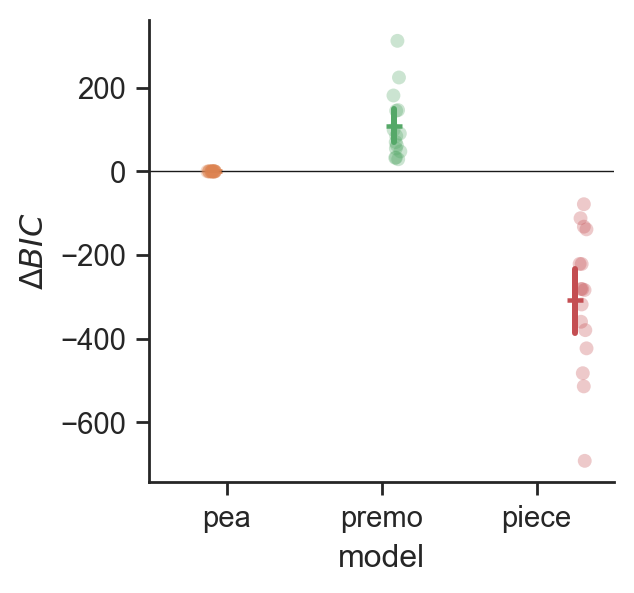

In [143]:
fig, ax = plt.subplots(figsize=(3, 3))
sns.despine()
sns.stripplot(
    data=fits, x="model", y="delta_bic", dodge=True, alpha=0.3, hue="model", 
    legend=False, order=["pea", "premo", "piece"], ax=ax
)
sns.pointplot(
    data=fits, x="model", y="delta_bic", hue="model", dodge=0.5,
    order=["pea", "premo", "piece"], **{"linestyle":"none", "marker":"_"},
    ax=ax
)
ax.axhline(y=0, color="k", linewidth=0.5)
ax.set(ylabel=r"$\Delta BIC$")
plt.show()

In [111]:
# Compute BIC deltas between models
idx_pea = fits["model"] == "pea"
idx_premo = fits["model"] == "premo"
idx_piece = fits["model"] == "piece"

# fits.groupby("subj_num")["bic"].

---
# Plot Models using MLEs ($\hat{\Theta}_{\text{MLE}}$) 

In [108]:
# Need a function to convert string back to numpy array
def converter(input_str):
    return np.fromstring(input_str[1:-1],sep=' ')

fits = pd.read_csv("../results/params_mle.csv", converters={"theta":converter})
fits.head()

,subj_num,model,theta,loglik,bic
0,1,ssm,"[-0.67436433, 2.09582467]",-2648.955385,5312.135425
1,1,pea,"[7.48772425, 0.22502893]",-2997.492435,6009.209524
2,1,premo,"[-0.20000007, 1.99999592, 2.00001135, 4.999996...",-3057.570274,6157.814512
3,1,piece,"[5.64749178, 0.05, 4.99993649]",-2752.690200,5526.717382
4,2,ssm,"[-0.73705783, 2.26128523]",-2742.189128,5498.602910


In [109]:
# Choose a sample subject
sid = 8
sample_subj = df.loc[df["SN"] == sid, :].reset_index(drop=True)
sigma_motor = sample_subj.loc[0, "motor_sd"]

# Pull out best-fit params for chosen subject:
params_idx = fits["subj_num"] == sid 
params = fits.loc[params_idx, ["theta", "model"]].iloc[0:4, :].reset_index(drop=True)

# Pull out MLEs for each model
ssm_mle = params.loc[params["model"] == "ssm", "theta"].values[0]
pea_mle = params.loc[params["model"] == "pea", "theta"].values[0]
premo_mle = params.loc[params["model"] == "premo", "theta"].values[0]
piece_mle = params.loc[params["model"] == "piece", "theta"].values[0]

# Find perturbation trials
pert_indices = np.flatnonzero(sample_subj["perturbation"])

# Simulate with best-fit parameters
_, xhat_ssm = ssm_ege(ssm_mle[0], ssm_mle[1], sample_subj["rotation"])
adapt_ssm = xhat_ssm[pert_indices + 1] - xhat_ssm[pert_indices - 1]

# PIECE model
_, xhat_piece = piece(
    piece_mle[0], 
    piece_mle[1], 
    piece_mle[2], 
    sigma_motor, len(sample_subj), 
    sample_subj["fbi"], 
    sample_subj["rotation"],
    fit=False
)
adapt_piece = xhat_piece[pert_indices + 1] - xhat_piece[pert_indices - 1]

# PEA model
_, xhat_pea = pea(
    pea_mle[0], 
    pea_mle[1], 
    sigma_motor, len(sample_subj), 
    sample_subj["fbi"], 
    sample_subj["rotation"],
    fit=False
)
adapt_pea = xhat_pea[pert_indices + 1] - xhat_pea[pert_indices - 1]

# PReMo 
_, xhat_premo = premo(
    premo_mle[0], 
    premo_mle[1],
    premo_mle[2], 
    premo_mle[3],
    premo_mle[4], 
    premo_mle[5],
    sigma_motor, len(sample_subj), 
    sample_subj["fbi"], 
    sample_subj["rotation"],
    fit=False
)
adapt_premo = xhat_premo[pert_indices + 1] - xhat_premo[pert_indices - 1]

# Create data frame with all perturbation trials
df1 = pd.DataFrame({
    "rotation":sample_subj.loc[pert_indices, "rotation"],
    "xhat_ssm":xhat_ssm[pert_indices],
    "adapt_ssm":adapt_ssm,
    "xhat_piece":xhat_piece[pert_indices],
    "adapt_piece":adapt_piece,
    "xhat_pea":xhat_pea[pert_indices],
    "adapt_pea":adapt_pea,
    "xhat_premo":xhat_premo[pert_indices],
    "adapt_premo":adapt_premo
})


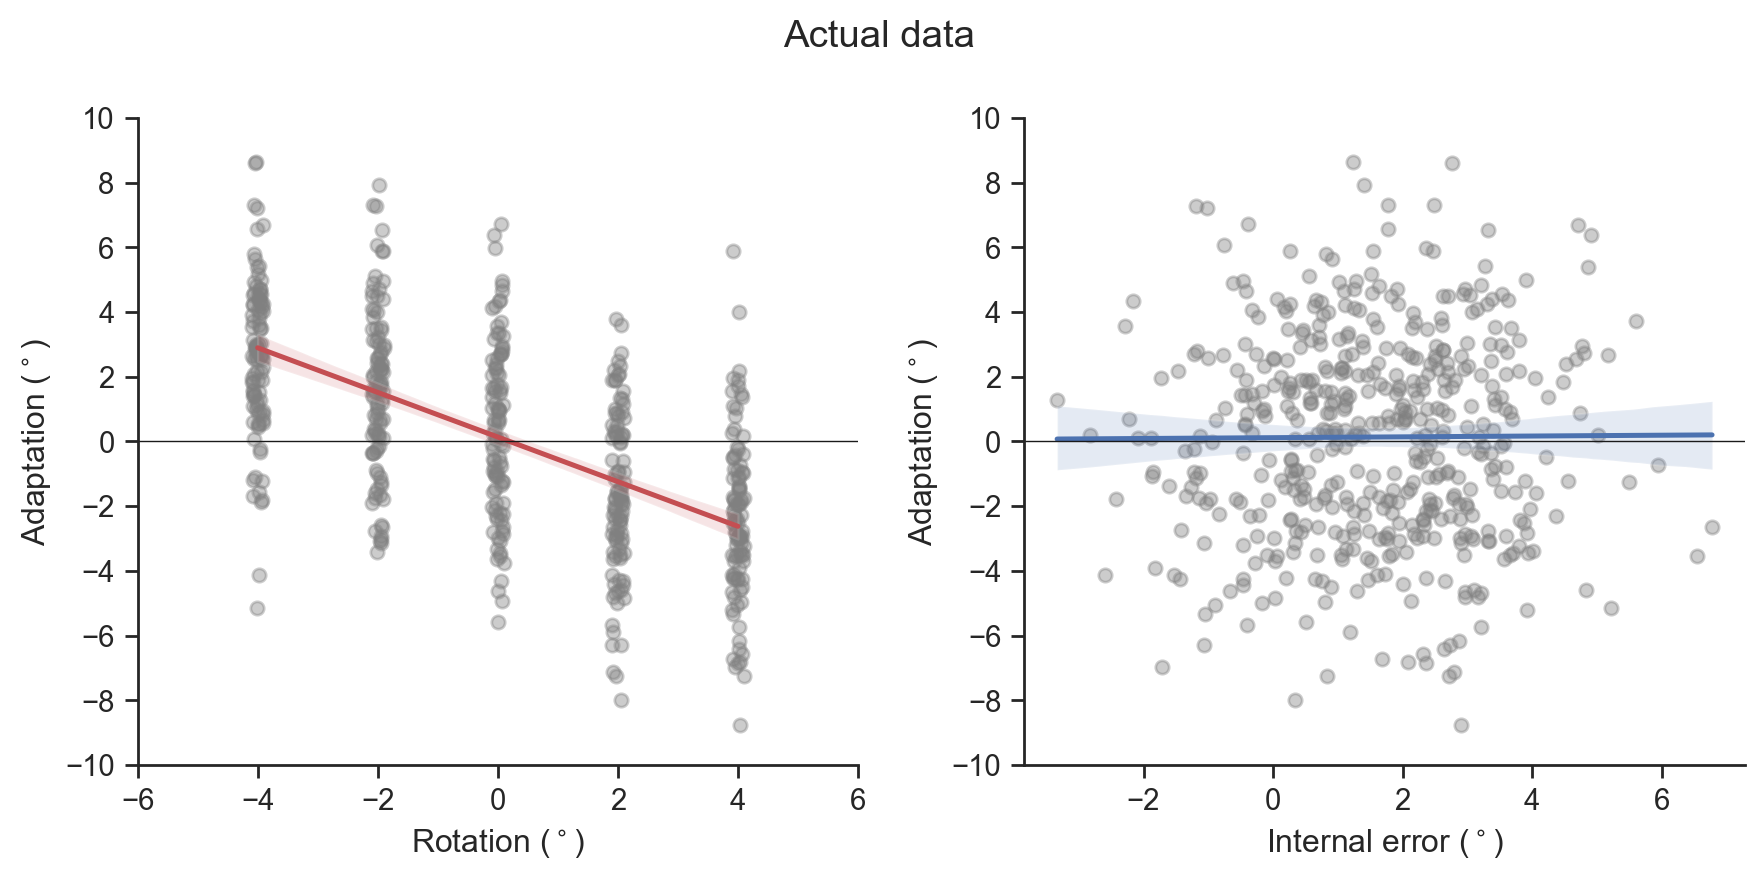

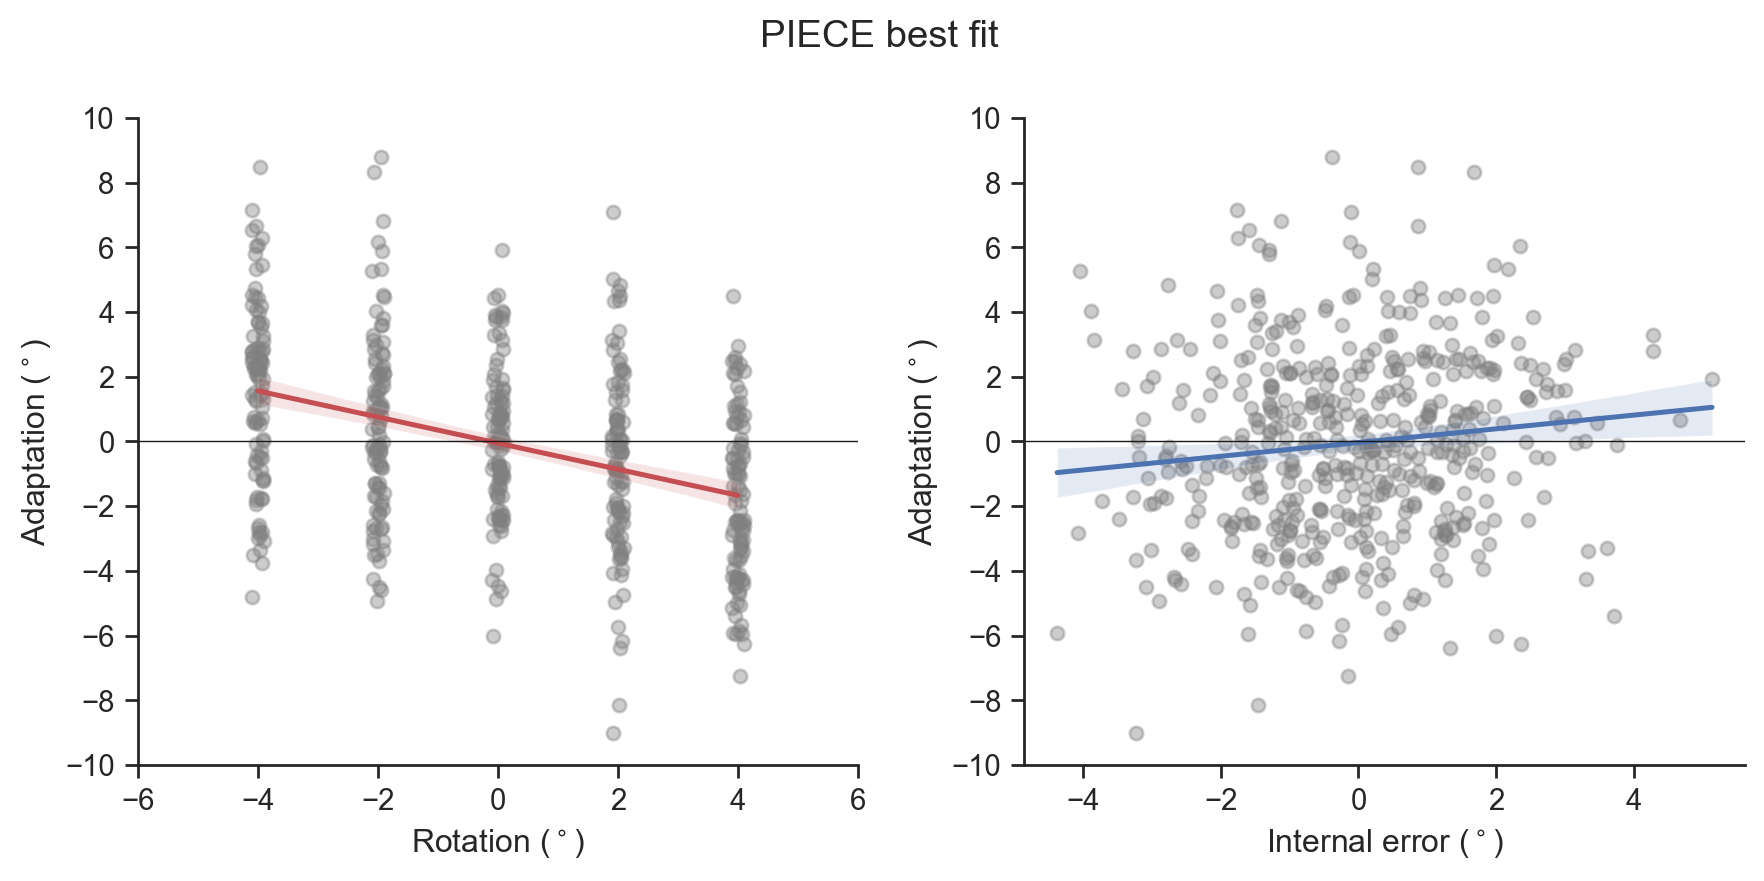

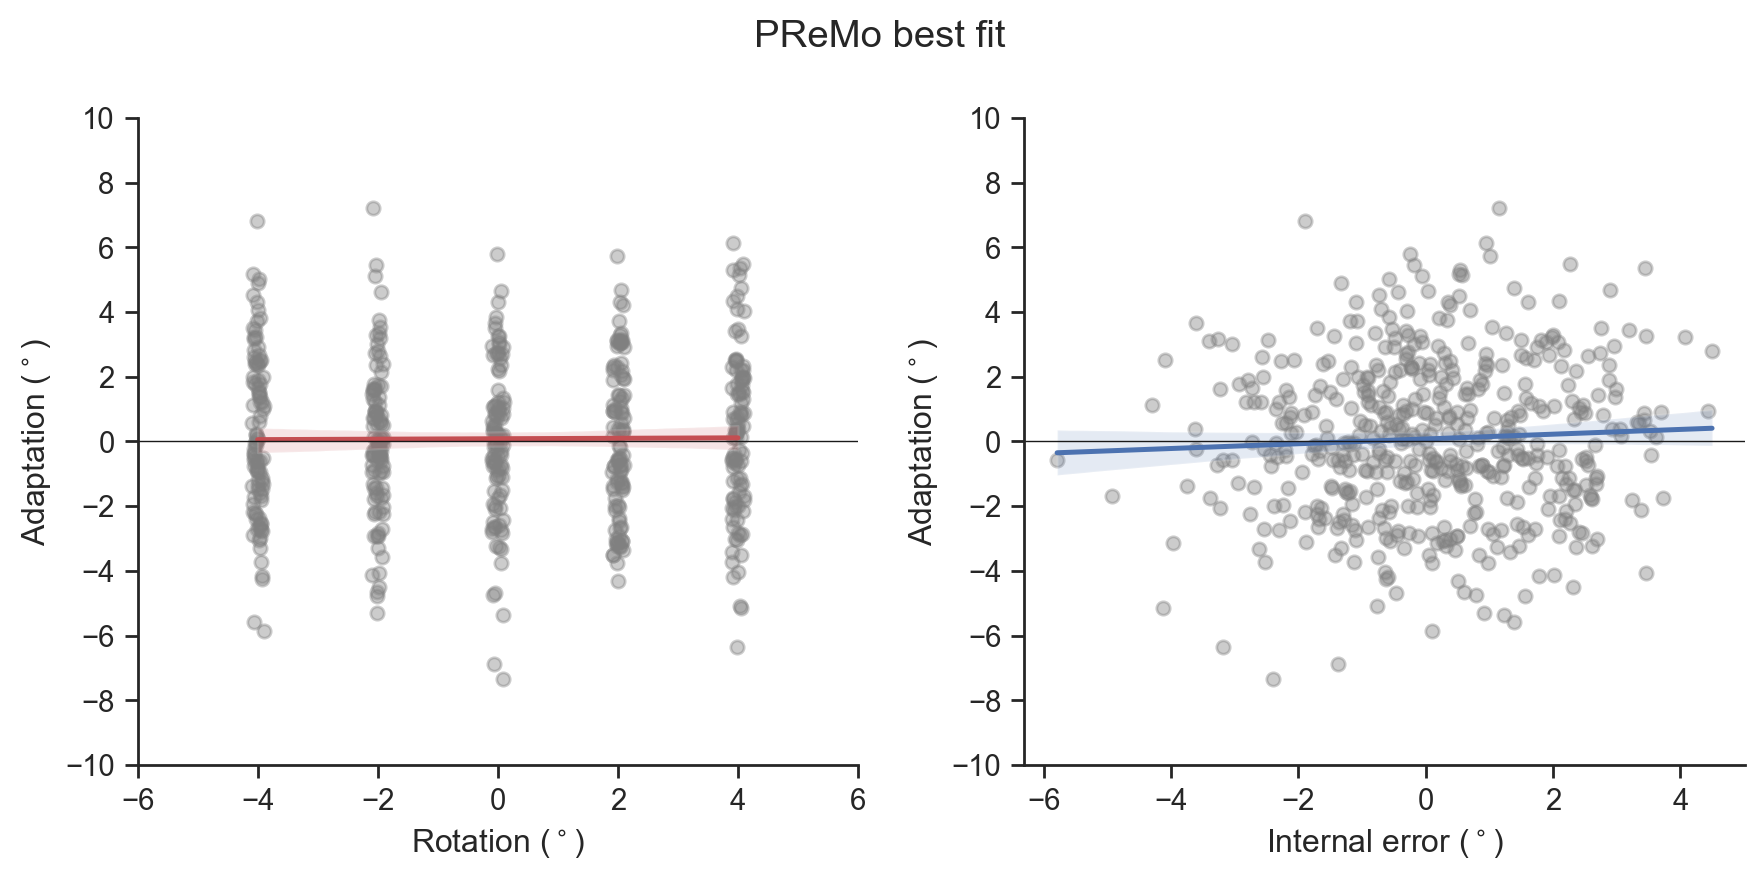

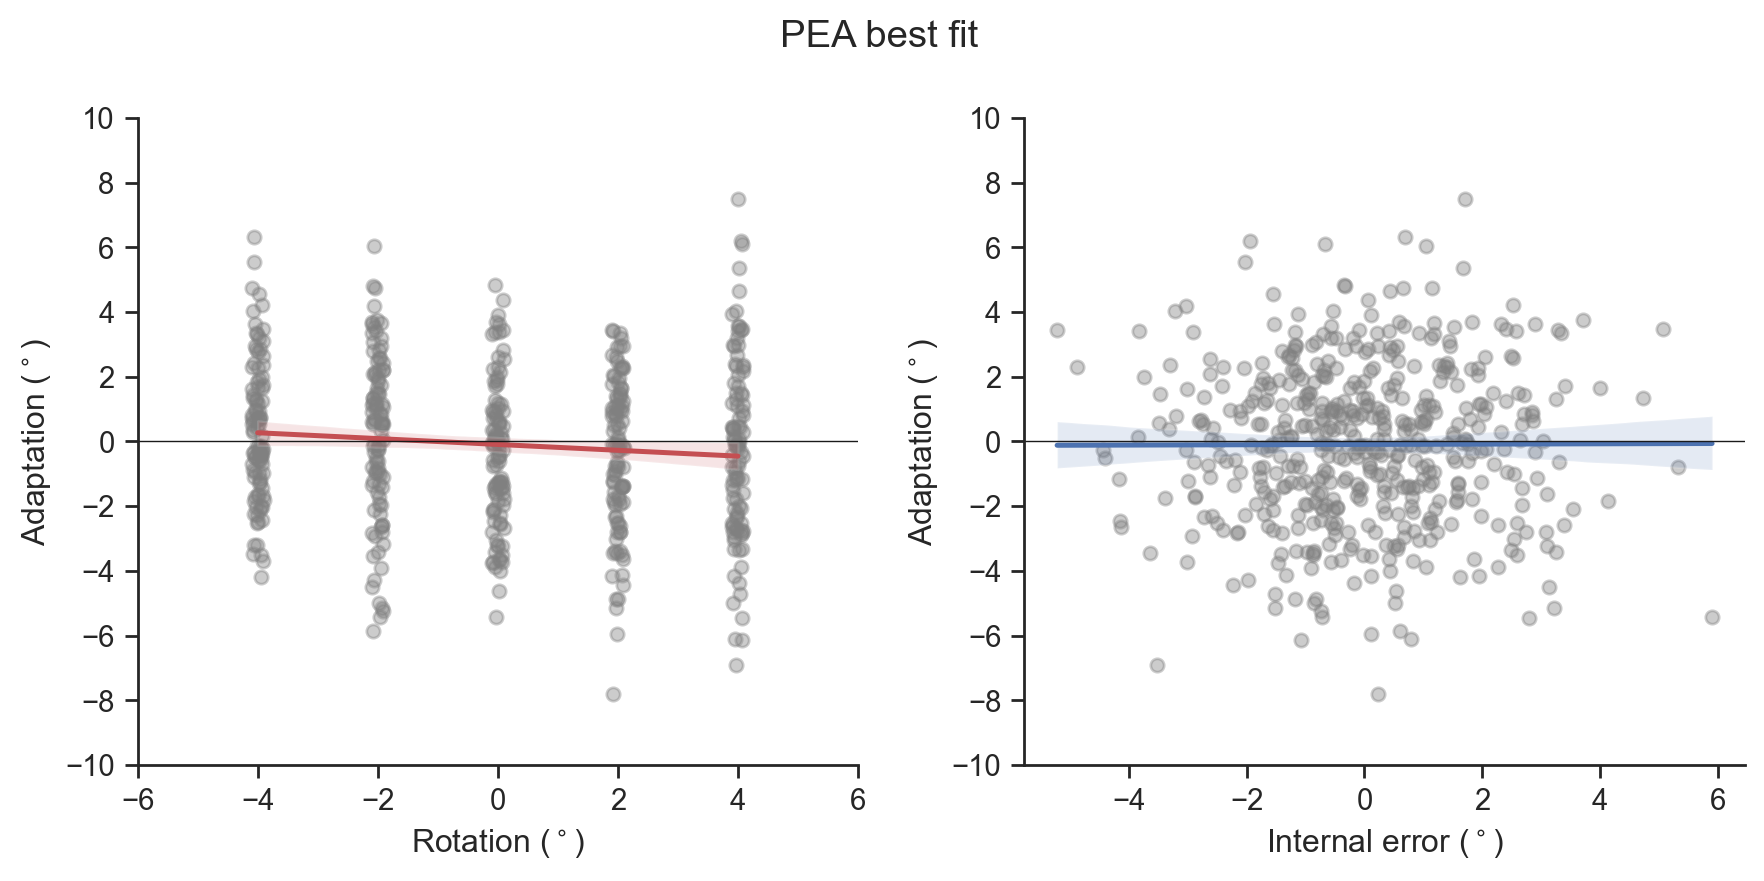

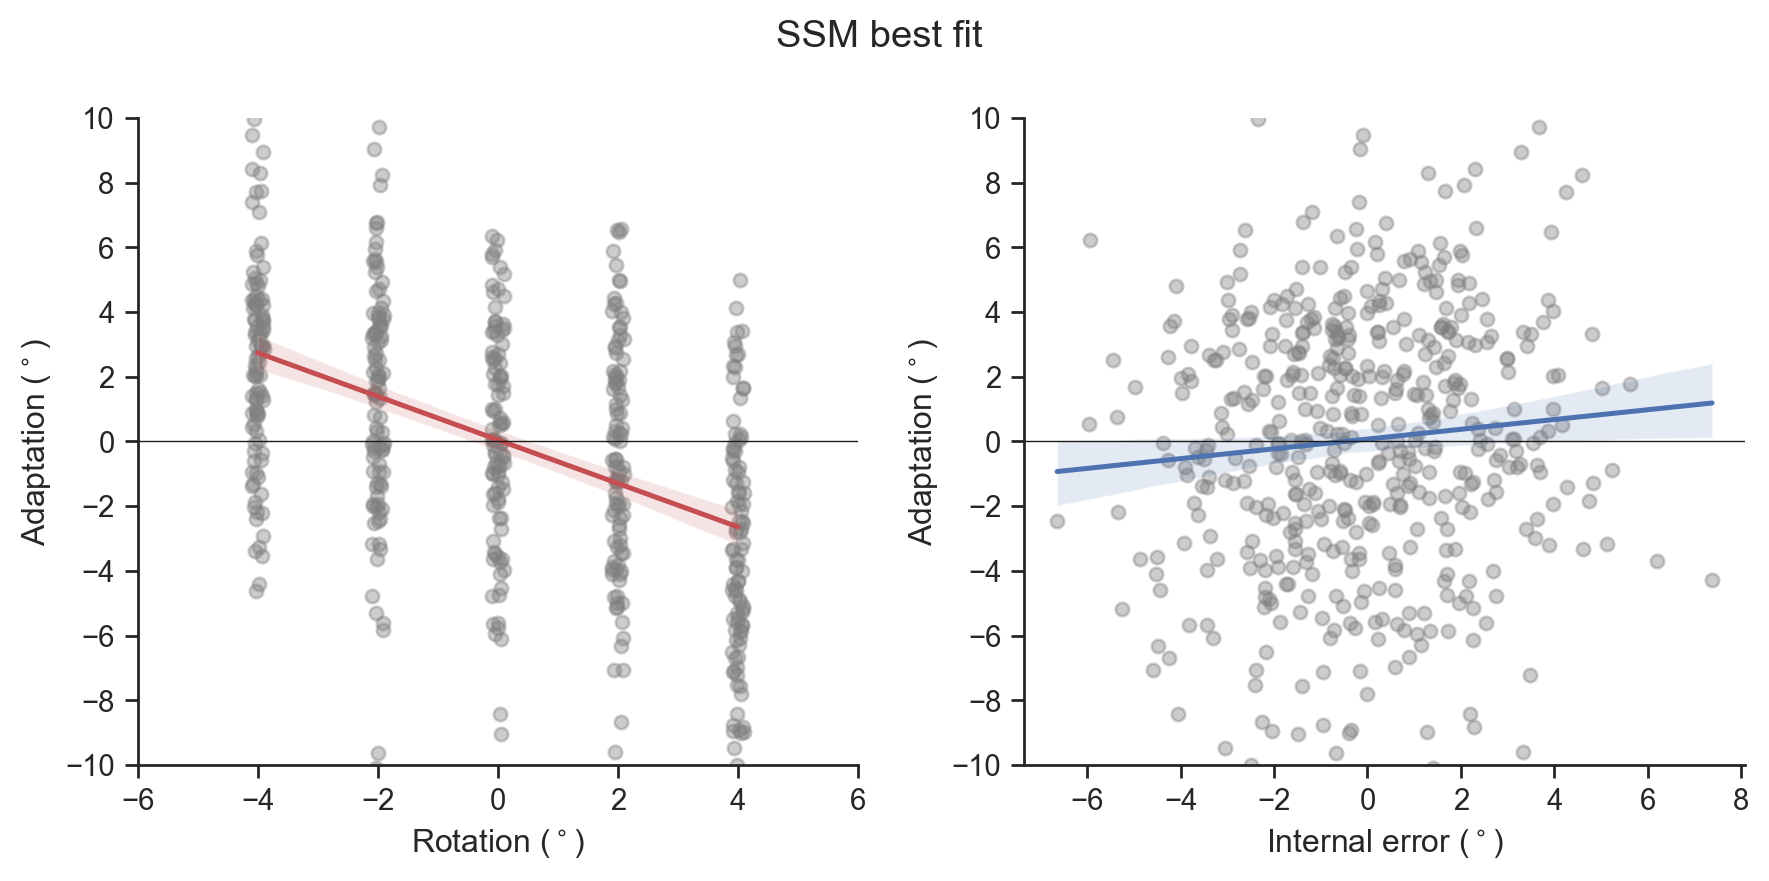

In [110]:
# Plot best-fits
plot_individual(sample_subj, "rotation", "theta_maxradv_clean", "adaptation", "Actual data")
plot_individual(df1, "rotation", "xhat_piece", "adapt_piece", "PIECE best fit")
plot_individual(df1, "rotation", "xhat_premo", "adapt_premo", "PReMo best fit")
plot_individual(df1, "rotation", "xhat_pea", "adapt_pea", "PEA best fit")
plot_individual(df1, "rotation", "xhat_ssm", "adapt_ssm", "SSM best fit")
